In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

import mpl_axes_aligner

In [3]:
def biplot(dfScores: pd.DataFrame, dfLoadings: pd.DataFrame) -> None:
    
    #create figure and axis objects
    fig,ax = plt.subplots(figsize=(15,8))
    
    #make a scores plot
    ax.scatter(dfScores.PC1.values,dfScores.PC2.values, color='b')
    #set x-axis label
    ax.set_xlabel("PC1",fontsize=10)
    #set y-axis label
    ax.set_ylabel("PC2",fontsize=10)
    
    ax.axvline(0, -15, 15)
    ax.axhline(0, -15, 15)
    
    #create a second set of axes
    ax2 = ax.twinx().twiny()
    
    #setup font dictionary
    font = {'color':  'g',
            'weight': 'bold',
            'size': 12,
            }
    
    #make a loadings plot
    for col in dfLoadings.columns.values:
        #where do our loading vectors end?
        tipx = dfLoadings.loc['PC1',col]
        tipy = dfLoadings.loc['PC2',col]
        #draw the vector, and write label text for col
        ax2.arrow(0, 0, tipx, tipy, color = 'r', alpha = 0.5)
        ax2.text(tipx*1.05, tipy*1.05, col, fontdict = font, ha = 'center', va = 'center')
    
    #align x = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
    #align y = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)
    
    #show plot
    plt.show()

In [4]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('top_level_filename')))
DATA_DIR = os.path.join(ROOT_DIR, 'data')
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'test.csv')
CENSUS_PATH = os.path.join(DATA_DIR, 'census_starter.csv')
MD_PATH = os.path.join(DATA_DIR, 'md-counties.csv')

In [ ]:
kaggle = KaggleApi()
kaggle.authenticate()
kaggle.competition_download_files(competition='godaddy-microbusiness-density-forecasting', path=DATA_DIR)

In [5]:
df = pd.read_csv(CENSUS_PATH)
df['cfips'] = df.loc[:, 'cfips'].astype('str')
col_list = df.columns
df = df[[c for c in col_list if ('2019' in c) or ('2020' in c) or ('2021' in c) or ('2022' in c) or ('cfips' in c)]]

df.columns

Index(['pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'cfips',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2019', 'pct_it_workers_2020',
       'pct_it_workers_2021', 'median_hh_inc_2019', 'median_hh_inc_2020',
       'median_hh_inc_2021'],
      dtype='object')

In [7]:
df_md = pd.read_csv(MD_PATH).dropna(subset=['cfips'])
df_md['cfips'] = df_md.loc[:, 'cfips'].astype('int').astype('str')
cfips = df_md.pop('cfips')
df_md = df_md[[c for c in df_md.columns if ('md' in c) and (('19' in c) or ('20' in c) or ('21' in c) or ('22' in c))]]
df_md['cfips'] = cfips

for y, c in zip(range(19, 23), ['md19', 'md20', 'md21', 'md22']):
    df_md[c] = df_md[[c for c in df_md if (str(y) in c)]].mean(axis=1)
    
df_md = df_md[['md19', 'md20', 'md21', 'md22', 'cfips']]

In [8]:
df_final = df.merge(df_md, on='cfips', how='left').dropna()

df_final

,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,md19,md20,md21,md22
0,80.6,82.7,85.5,1001,16.1,16.7,16.4,2.3,2.3,2.1,0.7,0.6,1.1,58731,57982.0,62660.0,0.531221,0.529512,0.489824,2.999106
1,81.8,85.1,87.9,1003,21.0,20.2,20.6,3.7,3.4,3.5,1.4,1.0,1.3,58320,61756.0,64346.0,7.629909,8.086201,7.438599,7.569062
2,60.5,64.6,64.6,1005,7.6,7.3,6.7,2.7,2.6,2.6,0.8,1.1,0.8,32525,34990.0,36422.0,0.486296,0.438661,0.439646,1.089847
3,69.2,76.1,74.6,1007,6.5,7.4,7.9,1.5,1.6,1.1,1.6,1.7,2.1,47542,51721.0,54277.0,0.225185,0.295221,0.297652,1.182312
4,73.0,79.6,81.0,1009,8.6,8.9,9.3,4.5,4.4,4.5,0.9,1.1,0.9,49358,48922.0,52830.0,0.155549,0.154304,0.132831,1.595581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,84.0,86.7,88.4,56037,14.8,13.7,12.4,4.7,5.2,5.5,1.0,0.9,1.0,74843,73384.0,76668.0,2.998987,3.207668,3.124674,2.625667
3138,87.1,89.1,90.5,56039,38.9,37.2,38.3,11.8,11.4,11.1,1.4,1.5,2.0,84678,87053.0,94498.0,26.864993,27.426846,24.460867,24.948688
3139,89.5,91.4,90.6,56041,11.1,12.6,12.3,2.9,2.9,2.9,1.4,1.7,0.9,63403,72458.0,75106.0,4.336937,4.129408,3.422722,3.761367
3140,78.2,82.8,85.4,56043,15.4,15.0,17.2,1.6,2.2,1.0,0.9,0.9,1.1,54158,57306.0,62271.0,0.539932,0.517214,0.486306,2.555831


In [9]:
features = ['pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2019', 'pct_it_workers_2020',
       'pct_it_workers_2021', 'median_hh_inc_2019', 'median_hh_inc_2020',
       'median_hh_inc_2021']

raw_X = df_final.loc[:, features]
X = StandardScaler().fit_transform(df_final.loc[:, features].values)
y = df_final[['md19', 'md20', 'md21', 'md22']]

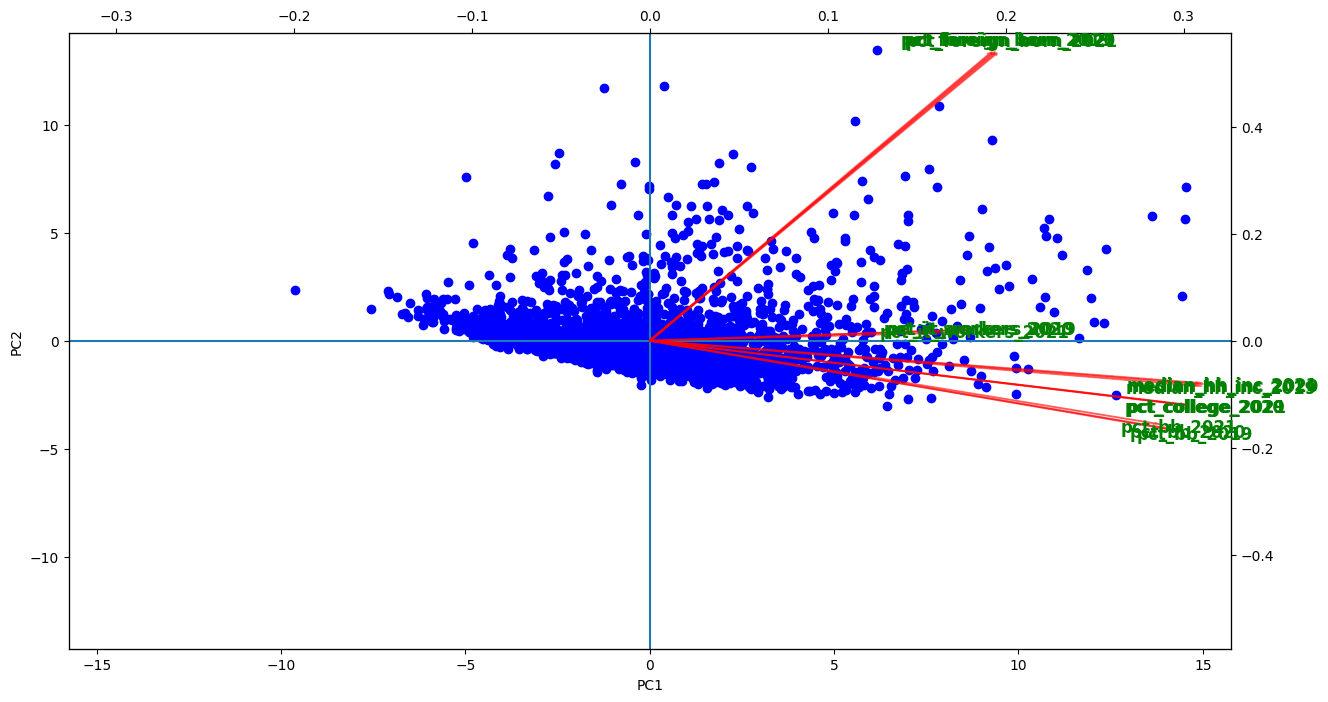

In [10]:
pca = PCA()

scores = pca.fit_transform(X, y)
dfScores   = pd.DataFrame(scores,columns=['PC'+str(i) for i in range(1,raw_X.shape[1]+1)])
dfLoadings = pd.DataFrame(pca.components_,columns=raw_X.columns,index=dfScores.columns)

biplot(dfScores, dfLoadings)

<BarContainer object of 4 artists>

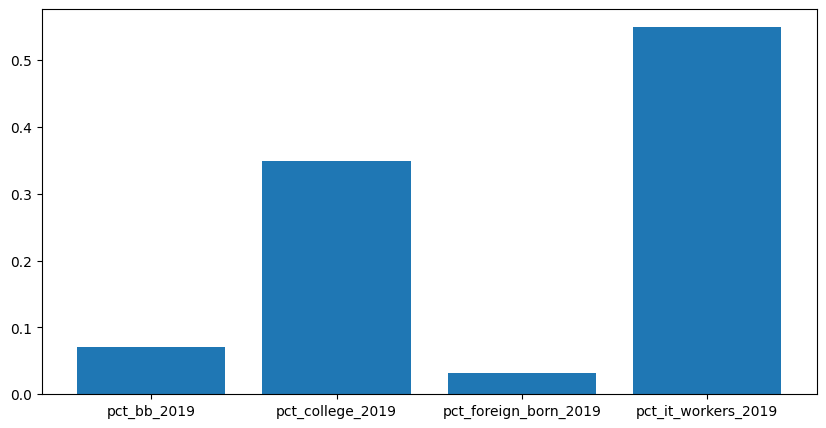

In [11]:
X = df_final[['pct_bb_2019', 'pct_college_2019', 'pct_foreign_born_2019', 'pct_it_workers_2019']].values
y = df_final['md19'].values
linreg = DecisionTreeRegressor()
linreg.fit(X, y)
imp = linreg.feature_importances_

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(['pct_bb_2019', 'pct_college_2019', 'pct_foreign_born_2019', 'pct_it_workers_2019'], imp)

<BarContainer object of 4 artists>

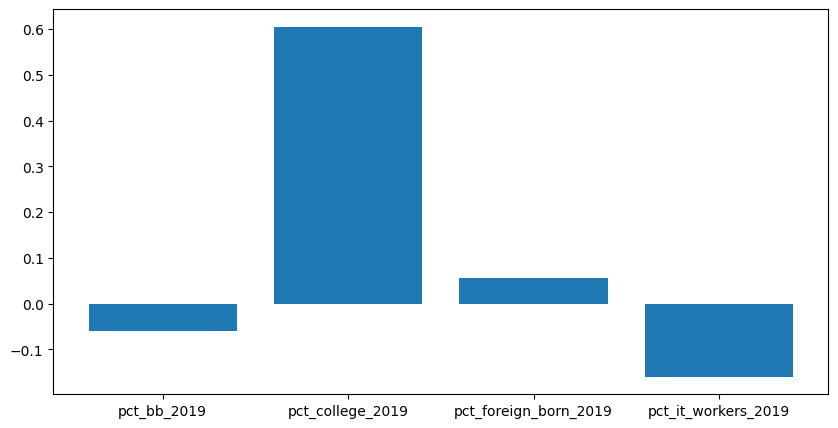

In [12]:
X = df_final[['pct_bb_2019', 'pct_college_2019', 'pct_foreign_born_2019', 'pct_it_workers_2019']].values
y = df_final['md19'].values
linreg = LinearRegression()
linreg.fit(X, y)
imp = linreg.coef_

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(['pct_bb_2019', 'pct_college_2019', 'pct_foreign_born_2019', 'pct_it_workers_2019'], imp)

<BarContainer object of 4 artists>

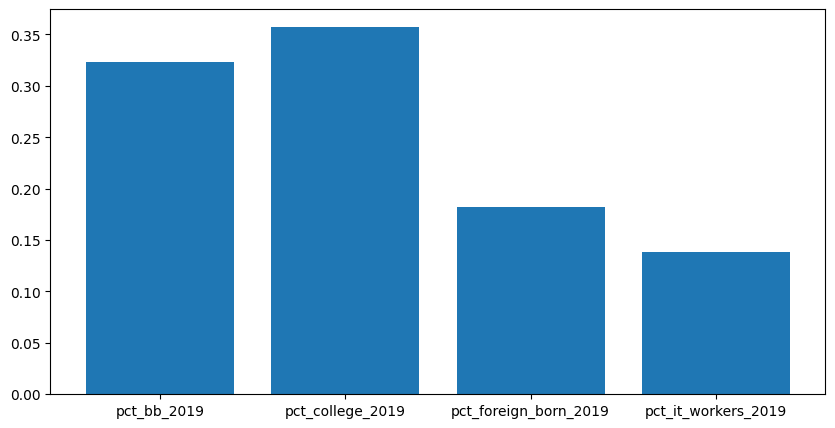

In [14]:
X = df_final[['pct_bb_2019', 'pct_college_2019', 'pct_foreign_born_2019', 'pct_it_workers_2019']].values
y = df_final['md19'].values
linreg = RandomForestRegressor()
linreg.fit(X, y)
imp = linreg.feature_importances_

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(['pct_bb_2019', 'pct_college_2019', 'pct_foreign_born_2019', 'pct_it_workers_2019'], imp)

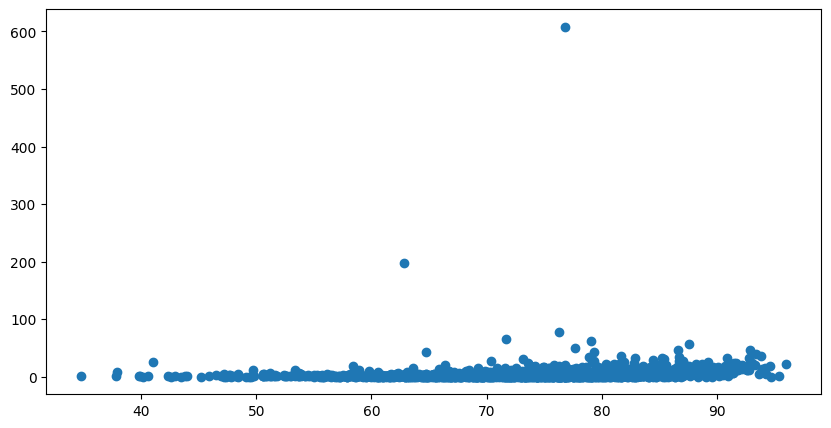

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(X[:, 0], y)
